# **Bus Need Classifier Preprocessing V5**

*Updates from V4: Switched to larger 2017 dataset and made corresponding changes.*

This notebook is for preprocessing data from the 2017 National Household Travel Survey to train a classifier. The classifier will be able to identify whether a given student needs a school bus or not based on basic demographic information maintained by a school as well as information that can be derived from the student's address.

The codebook used for translating the survey's encodings can be found here: https://nhts.ornl.gov/documentation

The User Guide for interpreting survey data (including instructions on merging dataframes) can be found here: https://nhts.ornl.gov/media/2017/doc/NHTS2017_UsersGuide_04232019_1.pdf

Citation: Federal Highway Administration. (2017). 2017 National Household Travel Survey, U.S. Department of Transportation, Washington, DC. Available online: https://nhts.ornl.gov.

Import pandas and load in the three datasets (household, person, and trip) found at: https://nhts.ornl.gov/downloads from the 2022
 CSV zip.

In [1]:
import pandas as pd

hh = pd.read_csv('hhpub.csv')
person = pd.read_csv('perpub.csv')
trip = pd.read_csv('trippub.csv')

print("Household shape:", hh.shape)
print("Person shape:", person.shape)
print("Trip shape:", trip.shape)


Household shape: (129696, 58)
Person shape: (264234, 121)
Trip shape: (923572, 115)


In [2]:
hh.head()

,HOUSEID,TRAVDAY,SAMPSTRAT,HOMEOWN,HHSIZE,HHVEHCNT,HHFAMINC,PC,SPHONE,TAB,...,SMPLSRCE,WTHHFIN,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN
0,30000007,2,3,1,3,5,7,2,1,2,...,2,187.314320,T,50,1500,750,750,20,750,300
1,30000008,5,2,1,2,4,8,1,1,2,...,2,69.513032,R,5,300,300,150,5,300,300
2,30000012,5,3,1,1,2,10,1,1,3,...,2,79.419586,C,80,17000,17000,5000,60,17000,7000
3,30000019,5,3,1,2,2,3,1,5,5,...,2,279.143588,S,40,300,300,150,50,750,300
4,30000029,3,3,1,2,2,5,2,5,1,...,2,103.240304,S,40,1500,750,750,40,1500,750


In [3]:
person.head()

,HOUSEID,PERSONID,R_AGE,EDUC,R_HISP,R_RELAT,R_SEX,R_RACE,PRMACT,PAYPROF,...,SMPLSRCE,WTPERFIN,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN
0,30000007,1,67,3,2,1,2,2,6,2,...,2,206.690153,T,50,1500,750,750,20,750,300
1,30000007,2,66,3,2,2,1,2,1,-1,...,2,197.075742,T,50,1500,750,750,20,750,300
2,30000007,3,28,2,2,3,2,2,5,2,...,2,219.514210,T,50,1500,750,750,20,750,300
3,30000008,1,55,5,2,1,1,1,1,-1,...,2,63.185911,R,5,300,300,150,5,300,300
4,30000008,2,49,4,2,2,2,1,1,-1,...,2,58.665911,R,5,300,300,150,5,300,300


In [4]:
trip.head()

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,OBHTNRNT,OBPPOPDN,OBRESDN,DTHTNRNT,DTPPOPDN,DTRESDN,DTEEMPDN,DBHTNRNT,DBPPOPDN,DBRESDN
0,30000007,1,1,1000,1015,15,5.244,3,0,0,...,20,750,300,50,750,300,350,30,300,300
1,30000007,1,2,1510,1530,20,5.149,3,0,0,...,30,300,300,50,1500,750,750,20,750,300
2,30000007,2,1,700,900,120,84.004,6,0,0,...,40,1500,750,50,1500,750,750,20,750,300
3,30000007,2,2,1800,2030,150,81.628,6,0,0,...,20,750,300,40,1500,750,750,40,1500,750
4,30000007,3,1,845,900,15,2.250,3,0,0,...,20,750,300,50,750,300,350,60,750,300


Merge the PERSON and HOUSEHOLD dataframes onto the TRIP dataframe. TRIP will have the most rows (one for each trip), where one person/household may have taken several trips. So, duplicate rows in HOUSEHOLD and PERSON accordingly using HOUSEID and PERSONID as keys to merge these three together.

In [5]:
# Ensure key columns are same type (string) to avoid mismatches, then merge on both HOUSEID & PERSONID.
for df, cols in [(trip, ['HOUSEID','PERSONID']), (person, ['HOUSEID','PERSONID']), (hh, ['HOUSEID'])]:
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype(str)

# Merge Trip with Person using both keys (this will replicate person info for each trip)
trip_person = trip.merge(person, on=['HOUSEID','PERSONID'], how='left', suffixes=('_TRIP','_PERSON'))

# Merge with Household on HOUSEID (household info replicated for each trip/person row)
combined = trip_person.merge(hh, on='HOUSEID', how='left', suffixes=('','_HH'))

print("trip shape:", trip.shape)
print("trip_person shape:", trip_person.shape, "combined shape:", combined.shape)


trip shape: (923572, 115)
trip_person shape: (923572, 234) combined shape: (923572, 291)


Verify that the number of unique households, persons, and trips is maintained.

In [6]:
print("Unique households in original hh:", hh['HOUSEID'].nunique())
print("Unique persons in original person:", person[['HOUSEID','PERSONID']].drop_duplicates().shape[0])
print("Unique trips in original trip:", trip.shape[0])

print("\nAfter merge:")
print("Unique households in combined:", combined['HOUSEID'].nunique())
print("Unique persons in combined:", combined[['HOUSEID','PERSONID']].drop_duplicates().shape[0])
print("Total trip-person-household rows:", combined.shape[0])

hh_per_trip = combined['HOUSEID'].nunique() / combined.shape[0]
person_per_trip = combined[['HOUSEID','PERSONID']].drop_duplicates().shape[0] / combined.shape[0]
print(f"\nRatio of unique households to total rows: {hh_per_trip:.4f}")
print(f"Ratio of unique persons to total rows: {person_per_trip:.4f}")

Unique households in original hh: 129696
Unique persons in original person: 264234
Unique trips in original trip: 923572

After merge:
Unique households in combined: 117222
Unique persons in combined: 219194
Total trip-person-household rows: 923572

Ratio of unique households to total rows: 0.1269
Ratio of unique persons to total rows: 0.2373


Double check that the losses occured only due to reported households/persons that did NOT make any trips instead of faulty merging.

In [7]:
# Step 1: Verify ID consistency
print("Trip HOUSEID examples:", trip['HOUSEID'].astype(str).head().tolist())
print("Person HOUSEID examples:", person['HOUSEID'].astype(str).head().tolist())
print("HH HOUSEID examples:", hh['HOUSEID'].astype(str).head().tolist())

# Step 2: Compare sets to see mismatch counts
trip_ids = set(trip['HOUSEID'].astype(str))
person_ids = set(person['HOUSEID'].astype(str))
hh_ids = set(hh['HOUSEID'].astype(str))

print("Trip households not in HH:", len(trip_ids - hh_ids))
print("Trip households not in Person:", len(trip_ids - person_ids))
print("Person households not in HH:", len(person_ids - hh_ids))


Trip HOUSEID examples: ['30000007', '30000007', '30000007', '30000007', '30000007']
Person HOUSEID examples: ['30000007', '30000007', '30000007', '30000008', '30000008']
HH HOUSEID examples: ['30000007', '30000008', '30000012', '30000019', '30000029']
Trip households not in HH: 0
Trip households not in Person: 0
Person households not in HH: 0


In [8]:
# Households in HH not represented in any trip
hh_not_in_trip = set(hh['HOUSEID']) - set(trip['HOUSEID'])
print("Households in HH but not in Trip:", len(hh_not_in_trip))

# Persons in Person file not represented in any trip
person_pairs = set(zip(person['HOUSEID'], person['PERSONID']))
trip_pairs = set(zip(trip['HOUSEID'], trip['PERSONID']))
persons_not_in_trip = person_pairs - trip_pairs
print("Persons in Person but not in Trip:", len(persons_not_in_trip))


Households in HH but not in Trip: 12474
Persons in Person but not in Trip: 45040


7893 - 6188 = 1705
16997 - 10592 = 6405
All losses of households/persons only occur for households/persons with no trips taken.

Filter to only include trips made by people who attend school (filter the 'SCHTYP' column for 1's) (edited from SCHOOL1 == 1 from 2022 codebook)


**Limitation Note: This dataset was created by surveying (mostly) adults across the United States on the behaviour of their household members. As a result, there will be inherent mistakes from adults misreporting the travel activity of their children. There will also be inherent biases; students who are more likely to use a school bus due to adverse household environments are less likely to have parents who will participate in this survery, for example.**

In [9]:
student_trips = combined[combined['SCHTYP'] == 1].copy()

print("Original combined shape:", combined.shape)
print("Filtered school trips shape:", student_trips.shape)

Original combined shape: (923572, 291)
Filtered school trips shape: (89447, 291)


In [11]:
# Display first 10 rows of school trips to inspect
student_trips.head(10)

# Optional: see key columns for verification
student_trips[['HOUSEID','PERSONID','WHYTO','TRPMILES','TRVLCMIN']].head(10)


,HOUSEID,PERSONID,WHYTO,TRPMILES,TRVLCMIN
121,30000144,2,13,2.140,43
122,30000144,2,8,2.426,30
123,30000144,2,11,1.057,18
124,30000144,2,1,0.000,61
125,30000144,3,13,2.140,43
126,30000144,3,8,2.426,30
127,30000144,3,11,1.057,18
128,30000144,3,1,0.000,61
219,30000302,3,8,7.738,19
220,30000302,3,13,3.204,12


Keep only necessary columns. We want columns that capture information about a student that can reasonabely be gathered or estimated from their address and demographics (urban/rural classification, geographic area, etc.)

(Removed some columns based on codebooko changes)

In [12]:
# List of feasible columns including identifiers
feasible_columns = [
    'HOUSEID', 'PERSONID',
    'TRPMILES', 'GASPRICE', 'NUMADLT_TRIP', 'HOMEOWN_TRIP',
    'CENSUS_D_TRIP', 'CENSUS_R_TRIP', 'HH_HISP_TRIP', 'DRVRCNT_TRIP',
    'CDIVMSAR_TRIP', 'HHFAMINC_TRIP', 'HH_RACE_TRIP',
    'HHSIZE_TRIP', 'HHVEHCNT_TRIP', 'LIF_CYC_TRIP', 'MSACAT_TRIP', 'MSASIZE_TRIP',
    'URBAN_TRIP', 'URBANSIZE_TRIP', 'URBRUR_TRIP', 'YOUNGCHILD', 'SCHTRN1', 'WHYTO'
]

# Filter the dataframe
student_trips_filtered = student_trips[feasible_columns].copy()

# Preview
print("Filtered dataframe shape:", student_trips_filtered.shape)
student_trips_filtered.head()


Filtered dataframe shape: (89447, 24)


,HOUSEID,PERSONID,TRPMILES,GASPRICE,NUMADLT_TRIP,HOMEOWN_TRIP,CENSUS_D_TRIP,CENSUS_R_TRIP,HH_HISP_TRIP,DRVRCNT_TRIP,...,HHVEHCNT_TRIP,LIF_CYC_TRIP,MSACAT_TRIP,MSASIZE_TRIP,URBAN_TRIP,URBANSIZE_TRIP,URBRUR_TRIP,YOUNGCHILD,SCHTRN1,WHYTO
121,30000144,2,2.140,207.6,1,2,7,3,2,0,...,0,3,2,5,1,4,1,0,11,13
122,30000144,2,2.426,207.6,1,2,7,3,2,0,...,0,3,2,5,1,4,1,0,11,8
123,30000144,2,1.057,207.6,1,2,7,3,2,0,...,0,3,2,5,1,4,1,0,11,11
124,30000144,2,0.000,207.6,1,2,7,3,2,0,...,0,3,2,5,1,4,1,0,11,1
125,30000144,3,2.140,207.6,1,2,7,3,2,0,...,0,3,2,5,1,4,1,0,11,13


Check for null values according to the survey's encoding:

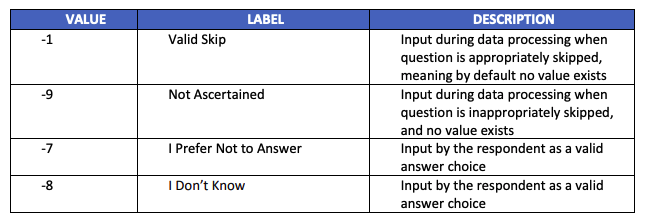

In [13]:
# Define the nonresponse codes
nonresponse_codes = [-1, -7, -8, -9]

# Initialize a dataframe to store counts
nonresponse_counts = pd.DataFrame(columns=['Column_Name', '-1', '-7', '-8', '-9'])

# Loop through each column and count nonresponse values
for col in student_trips_filtered.columns:
    counts = student_trips_filtered[col].isin(nonresponse_codes).groupby(student_trips_filtered[col]).sum()
    row = {
        'Column_Name': col,
        '-1': (student_trips_filtered[col] == -1).sum(),
        '-7': (student_trips_filtered[col] == -7).sum(),
        '-8': (student_trips_filtered[col] == -8).sum(),
        '-9': (student_trips_filtered[col] == -9).sum()
    }
    nonresponse_counts = pd.concat([nonresponse_counts, pd.DataFrame([row])], ignore_index=True)

# Show counts
nonresponse_counts

,Column_Name,-1,-7,-8,-9
0,HOUSEID,0,0,0,0
1,PERSONID,0,0,0,0
2,TRPMILES,0,0,0,89
3,GASPRICE,0,0,0,0
4,NUMADLT_TRIP,0,0,0,0
5,HOMEOWN_TRIP,0,8,0,0
6,CENSUS_D_TRIP,0,0,0,0
7,CENSUS_R_TRIP,0,0,0,0
8,HH_HISP_TRIP,0,58,0,0
9,DRVRCNT_TRIP,0,0,0,0


Drop all rows with -7 to -9 in the SCHTRN1 column, since this will be our target variable column.

Drop all rows with -9 in the TRPMILES column.

Everything else is a valid skip.

In [14]:
# Drop rows where SCHTRN1 == -7 -> -9 (invalid target variable)
student_trips_filtered = student_trips_filtered[student_trips_filtered['SCHTRN1'] != -7]
student_trips_filtered = student_trips_filtered[student_trips_filtered['SCHTRN1'] != -8]
student_trips_filtered = student_trips_filtered[student_trips_filtered['SCHTRN1'] != -9]

# Drop rows where TRPMILES = -9 (invalid mileage data)
student_trips_filtered = student_trips_filtered[student_trips_filtered['TRPMILES'] != -9]

# Reset index after dropping rows
student_trips_filtered = student_trips_filtered.reset_index(drop=True)

# Confirm changes
print(student_trips_filtered.shape)
student_trips_filtered['SCHTRN1'].value_counts()


(89328, 24)


,count
SCHTRN1,
3,31326
10,25763
4,13656
1,6555
5,5405
6,3694
2,1484
11,577
97,279


Clean up repeats, since one student may have taken multiple trips (multiple rows), including trips that are unrelated to school.

First, group any "similar" rows (rows with the same HOUSEID **and** PERSONID).

Create a new column called 'SCHOOL_DISTANCE' with blank values.

Among each group of "similar" rows, find all rows where 'WHYTO' == 6 (indicates the trip was to go to school). Take the median value for 'TRPMILES' for all of these rows and fill that value in for the 'SCHOOL_DISTANCE' column for all these rows.

If there are no rows where 'WHYTO' == 6, do nothing.

Drop the 'WHYTO', 'HOUSEID', 'PERSONID' columns.

Drop all repeat occurences of rows with the same HOUSEID and PERSONID.

For all rows with a 0 in the 'SCHOOL_DISTANCE' column, fill in with the median value of the column.

*changed WHYTO filter to 8 to match codebook

In [16]:
import numpy as np

# Make a copy to be safe
student_trips_filtered = student_trips_filtered.copy()

# Step 1: Create a blank SCHOOL_DISTANCE column
student_trips_filtered['SCHOOL_DISTANCE'] = np.nan

# Step 2: For each (HOUSEID, PERSONID) group, fill SCHOOL_DISTANCE with the median TRPMILES where WHYTO == 6
def assign_school_distance(group):
    school_trips = group[group['WHYTO'] == 8]['TRPMILES']
    if not school_trips.empty:
        median_distance = school_trips.median()
        group['SCHOOL_DISTANCE'] = median_distance
    return group

student_trips_filtered = student_trips_filtered.groupby(['HOUSEID', 'PERSONID'], group_keys=False).apply(assign_school_distance)

# Step 3: Drop the WHYTO column
student_trips_filtered = student_trips_filtered.drop(columns=['WHYTO'])

# Step 4: Drop duplicate rows with same HOUSEID and PERSONID (keep the first)
student_trips_filtered = student_trips_filtered.drop_duplicates(subset=['HOUSEID', 'PERSONID'])

# Step 5: Fill SCHOOL_DISTANCE = 0 with the column median
median_distance = student_trips_filtered.loc[student_trips_filtered['SCHOOL_DISTANCE'] > 0, 'SCHOOL_DISTANCE'].median()
student_trips_filtered['SCHOOL_DISTANCE'] = student_trips_filtered['SCHOOL_DISTANCE'].replace(0, np.nan)
student_trips_filtered['SCHOOL_DISTANCE'] = student_trips_filtered['SCHOOL_DISTANCE'].fillna(median_distance)

#drop HOUSEID and PERSONID columns
student_trips_filtered = student_trips_filtered.drop(columns=['HOUSEID'])
student_trips_filtered = student_trips_filtered.drop(columns=['PERSONID'])

# Step 6: Reset index
student_trips_filtered = student_trips_filtered.reset_index(drop=True)

# Confirm result
print(student_trips_filtered.shape)
student_trips_filtered.head()


(26208, 22)


/tmp/ipython-input-3825698315.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  student_trips_filtered = student_trips_filtered.groupby(['HOUSEID', 'PERSONID'], group_keys=False).apply(assign_school_distance)


,TRPMILES,GASPRICE,NUMADLT_TRIP,HOMEOWN_TRIP,CENSUS_D_TRIP,CENSUS_R_TRIP,HH_HISP_TRIP,DRVRCNT_TRIP,CDIVMSAR_TRIP,HHFAMINC_TRIP,...,HHVEHCNT_TRIP,LIF_CYC_TRIP,MSACAT_TRIP,MSASIZE_TRIP,URBAN_TRIP,URBANSIZE_TRIP,URBRUR_TRIP,YOUNGCHILD,SCHTRN1,SCHOOL_DISTANCE
0,2.140,207.6,1,2,7,3,2,0,72,5,...,0,3,2,5,1,4,1,0,11,2.426
1,2.140,207.6,1,2,7,3,2,0,72,5,...,0,3,2,5,1,4,1,0,11,2.426
2,7.738,207.9,2,1,7,3,2,3,72,11,...,3,8,2,5,1,4,1,0,3,7.738
3,0.702,208.7,2,1,6,3,2,2,62,8,...,2,4,2,4,1,3,1,1,10,15.403
4,2.767,239.5,2,2,2,1,2,2,23,3,...,1,6,3,1,1,1,1,0,10,2.625


Drop the TRPMILES column.

In [17]:
student_trips_filtered = student_trips_filtered.drop(columns=['TRPMILES'])

Quick check: how many unique students in our dataset usually use a school bus?

In [18]:
# Count how many students have SCHTRN1 == 10
mode_9_count = student_trips_filtered[student_trips_filtered['SCHTRN1'] == 10].shape[0]
total_students = student_trips_filtered.shape[0]

print(f"School trips with SCHTRN 9: {mode_9_count}")
print(f"Total students: {total_students}")
print(f"Percentage: {mode_9_count / total_students * 100:.2f}%")


School trips with SCHTRN 9: 7944
Total students: 26208
Percentage: 30.31%


Re encode the SCHTRN1 column to a binary NEEDS_SCHOOL_BUS column. Code 10 (formerly 9) indicates the student usually takes a bus to school, and all other codes indicate other means of transport.

**Limitation Note: This process assumes that every student who uses a school bus needs a school bus, and that if a student doesn't usually use a bus they do not need a bus. This is not always correct in practice, since many students might not use a bus because of bad bus service, even if they actually need it. Future changes to address this limitation might be to more carefully analyze what other modes of transport students use and for how many miles to help determine which students NEED a bus vs actually USE a bus.**

In [19]:
# Re-encode the SCHTRN1 column to indicate "needs school bus"
# Original column: SCHTRN1
# Rule: 10 → 1 (needs school bus), everything else → 0

student_trips_filtered['NEEDS_SCHOOL_BUS'] = student_trips_filtered['SCHTRN1'].apply(lambda x: 1 if x == 10 else 0)

# Optional: drop the original TRPTRANS column if no longer needed
student_trips_filtered = student_trips_filtered.drop(columns=['SCHTRN1'])

# Verify changes
student_trips_filtered[['NEEDS_SCHOOL_BUS']].head(30)

,NEEDS_SCHOOL_BUS
0,0
1,0
2,0
3,1
4,1
5,0
6,0
7,0
8,0
9,0


**One Hot Encoding**

First, download the codebook file and load it in. This codebook contains mappings for every code used for all categorical variables, as well as for some numerical variables.

In [20]:
codebook_df = pd.read_excel('codebook_v1.2.xlsx')
codebook_df.head()

,Name,Label,Type,Length,Code / Range,Frequency,Weighted
0,BIKE,Frequency of Bicycle Use for Travel,C,2.0,-9=Not ascertained,14661,1.378796e+07
1,NaN,NaN,NaN,NaN,-8=I don't know,10,1.090766e+04
2,NaN,NaN,NaN,NaN,-7=I prefer not to answer,5,3.267190e+04
3,NaN,NaN,NaN,NaN,01=Daily,1870,1.979683e+06
4,NaN,NaN,NaN,NaN,02=A few times a week,5363,4.961863e+06


Forward fill the variable names so that each code is associated with a column variable name.

In [21]:
# Forward fill the 'Name' column so each code row knows its variable
codebook_df['Name'] = codebook_df['Name'].ffill()
codebook_df.head()

,Name,Label,Type,Length,Code / Range,Frequency,Weighted
0,BIKE,Frequency of Bicycle Use for Travel,C,2.0,-9=Not ascertained,14661,1.378796e+07
1,BIKE,NaN,NaN,NaN,-8=I don't know,10,1.090766e+04
2,BIKE,NaN,NaN,NaN,-7=I prefer not to answer,5,3.267190e+04
3,BIKE,NaN,NaN,NaN,01=Daily,1870,1.979683e+06
4,BIKE,NaN,NaN,NaN,02=A few times a week,5363,4.961863e+06


Keep only the Name and Code / Range columns.

Our student_trips_filtered dataframe has column names based on the TRIPS file, which has _TRIPS appended to most of the column names. Clean up the column names in student_trips_filtered so they match the names in the codebook.

Filter the codebook so that only codes for variables actually present in our dataframe are preserved.

In [22]:
# Step 2: Keep only the relevant columns
codebook_df = codebook_df[['Name', 'Code / Range']]

# Step 3: Get your dataset’s column names
school_trip_cols = student_trips_filtered.columns

# Step 4: Clean up names to match between codebook and your df
# The codebook may use names like 'HHFAMINC' while your df uses 'HHFAMINC_TRIP'
# So we match ignoring trailing suffixes like '_TRIP'
base_names = [c.replace('_TRIP', '') for c in school_trip_cols]

# Step 5: Filter the codebook so we only keep rows whose Name matches one of these
filtered_codebook = codebook_df[codebook_df['Name'].isin(base_names)].copy()

# Step 6: Display the first few rows to confirm
filtered_codebook.head(20)

,Name,Code / Range
32,CDIVMSAR,"11=New England (ME, NH, VT, CT, MA, RI) MSA or..."
33,CDIVMSAR,"12=New England (ME, NH, VT, CT, MA, RI) MSA or..."
34,CDIVMSAR,"13=New England (ME, NH, VT, CT, MA, RI) MSA of..."
35,CDIVMSAR,"14=New England (ME, NH, VT, CT, MA, RI) Not in..."
36,CDIVMSAR,"21=Mid-Atlantic (NY, NJ, PA) MSA or CMSA of 1 ..."
37,CDIVMSAR,"22=Mid-Atlantic (NY, NJ, PA) MSA or CMSA of 1 ..."
38,CDIVMSAR,"23=Mid-Atlantic (NY, NJ, PA) MSA of less than ..."
39,CDIVMSAR,"24=Mid-Atlantic (NY, NJ, PA) Not in a MSA"
40,CDIVMSAR,"31=East North Central (IL, IN, MI, OH, WI) MSA..."
41,CDIVMSAR,"32=East North Central (IL, IN, MI, OH, WI) MSA..."


Several numerical variable columns are still listed in the codebook dataframe, so we should remove them.

In [23]:
# list of non-categorical variables to drop
non_categorical = ['DRVRCNT', 'HHFAMINC_IMP', 'HHSIZE', 'HHVEHCNT', 'NUMADLT', 'YOUNGCHILD']

# Remove these from the codebook subset
codebook_df = codebook_df[~codebook_df['Name'].isin(non_categorical)]

# Confirm the filtered codebook
codebook_df.head()

,Name,Code / Range
0,BIKE,-9=Not ascertained
1,BIKE,-8=I don't know
2,BIKE,-7=I prefer not to answer
3,BIKE,01=Daily
4,BIKE,02=A few times a week


Remove the _TRIP suffix from all columns in student_trips_filtered that have the suffix.

In [24]:
# Remove '_TRIP' suffix from all column names
student_trips_filtered.columns = [col.replace('_TRIP', '') for col in student_trips_filtered.columns]
student_trips_filtered.head()

,GASPRICE,NUMADLT,HOMEOWN,CENSUS_D,CENSUS_R,HH_HISP,DRVRCNT,CDIVMSAR,HHFAMINC,HH_RACE,...,HHVEHCNT,LIF_CYC,MSACAT,MSASIZE,URBAN,URBANSIZE,URBRUR,YOUNGCHILD,SCHOOL_DISTANCE,NEEDS_SCHOOL_BUS
0,207.6,1,2,7,3,2,0,72,5,2,...,0,3,2,5,1,4,1,0,2.426,0
1,207.6,1,2,7,3,2,0,72,5,2,...,0,3,2,5,1,4,1,0,2.426,0
2,207.9,2,1,7,3,2,3,72,11,1,...,3,8,2,5,1,4,1,0,7.738,0
3,208.7,2,1,6,3,2,2,62,8,1,...,2,4,2,4,1,3,1,1,15.403,1
4,239.5,2,2,2,1,2,2,23,3,1,...,1,6,3,1,1,1,1,0,2.625,1


To one hot encode, we can create a mapping dictionary that maps integer codes present in each column of student_trips_filtered to their corresponding "human readable column names" in the codebook dataframe.

Keep in mind that the numerical codes in the codebook dataframe appear as strings, but are integer entries in  student_trips_filtered, so str->int conversion is needed to match them.

Finally, we can use pd.get_dummies to one hot encode all the categorical columns, rewriting the auto-generated column names to the human readable versions using the mapping dictionary.

In [25]:
# Step 1: Build mapping dictionary
mapping_dict = {}
for var in codebook_df['Name'].unique():
    subset = codebook_df[codebook_df['Name'] == var]['Code / Range'].dropna()
    var_map = {}
    for entry in subset:
        if '=' in entry:
            code, label = entry.split('=', 1)
            try:
                var_map[int(code.strip())] = label.strip()
            except ValueError:
                var_map[code.strip()] = label.strip()
    mapping_dict[var] = var_map

# Step 2: Convert categorical columns to int where possible
for col in mapping_dict.keys():
    if col in student_trips_filtered.columns:
        try:
            student_trips_filtered[col] = student_trips_filtered[col].astype(int)
        except ValueError:
            pass

# Step 3: Identify categorical vars (binary or not)
categorical_vars = [col for col in mapping_dict.keys() if col in student_trips_filtered.columns]

# Step 4: One-hot encode WITHOUT dropping dummies (Random Forest does not require drop_first)
onehot_df = pd.get_dummies(
    student_trips_filtered,
    columns=categorical_vars,
    prefix=categorical_vars,
    dtype=int,
    drop_first=False   # <--- changed here
)

# Step 5: Rename one-hot columns to human-readable labels
new_columns = []
for col in onehot_df.columns:
    matched = False
    for var, code_map in mapping_dict.items():
        for code, label in code_map.items():
            if col == f"{var}_{code}":
                new_columns.append(f"{var}_{label}")
                matched = True
                break
        if matched:
            break
    if not matched:
        new_columns.append(col)

onehot_df.columns = new_columns

onehot_df.head()


,GASPRICE,NUMADLT,DRVRCNT,HHSIZE,HHVEHCNT,YOUNGCHILD,SCHOOL_DISTANCE,NEEDS_SCHOOL_BUS,"CDIVMSAR_New England (ME, NH, VT, CT, MA, RI) MSA or CMSA of 1 million or more with heavy rail","CDIVMSAR_New England (ME, NH, VT, CT, MA, RI) MSA or CMSA of 1 million or more without heavy rail",...,URBAN_In an area surrounded by urban areas,URBAN_Not in urban area,"URBANSIZE_50,000 - 199,999","URBANSIZE_200,000 - 499,999","URBANSIZE_500,000 - 999,999",URBANSIZE_1 million or more without heavy rail,URBANSIZE_1 million or more with heavy rail,URBANSIZE_Not in an urbanized area,URBRUR_Urban,URBRUR_Rural
0,207.6,1,0,3,0,0,2.426,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,207.6,1,0,3,0,0,2.426,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,207.9,2,3,3,3,0,7.738,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,208.7,2,2,4,2,1,15.403,1,0,0,...,0,0,0,0,1,0,0,0,1,0
4,239.5,2,2,3,1,0,2.625,1,0,0,...,0,0,1,0,0,0,0,0,1,0


Verify the one hot encoding and renaming.

In [26]:
# Get the dimensions
print("Shape of the one-hot encoded dataframe:", onehot_df.shape)

# Print all column names neatly
print("Columns:")
for col in onehot_df.columns:
    print(col)


Shape of the one-hot encoded dataframe: (26208, 110)
Columns:
GASPRICE
NUMADLT
DRVRCNT
HHSIZE
HHVEHCNT
YOUNGCHILD
SCHOOL_DISTANCE
NEEDS_SCHOOL_BUS
CDIVMSAR_New England (ME, NH, VT, CT, MA, RI) MSA or CMSA of 1 million or more with heavy rail
CDIVMSAR_New England (ME, NH, VT, CT, MA, RI) MSA or CMSA of 1 million or more without heavy rail
CDIVMSAR_New England (ME, NH, VT, CT, MA, RI) MSA of less than 1 million
CDIVMSAR_New England (ME, NH, VT, CT, MA, RI) Not in a MSA
CDIVMSAR_Mid-Atlantic (NY, NJ, PA) MSA or CMSA of 1 million or more with heavy rail
CDIVMSAR_Mid-Atlantic (NY, NJ, PA) MSA or CMSA of 1 million or more without heavy rail
CDIVMSAR_Mid-Atlantic (NY, NJ, PA) MSA of less than 1 million
CDIVMSAR_Mid-Atlantic (NY, NJ, PA) Not in a MSA
CDIVMSAR_East North Central (IL, IN, MI, OH, WI) MSA or CMSA of 1 million or more with heavy rail
CDIVMSAR_East North Central (IL, IN, MI, OH, WI) MSA or CMSA of 1 million or more without heavy rail
CDIVMSAR_East North Central (IL, IN, MI, OH, WI)

Make a correlation matrix.

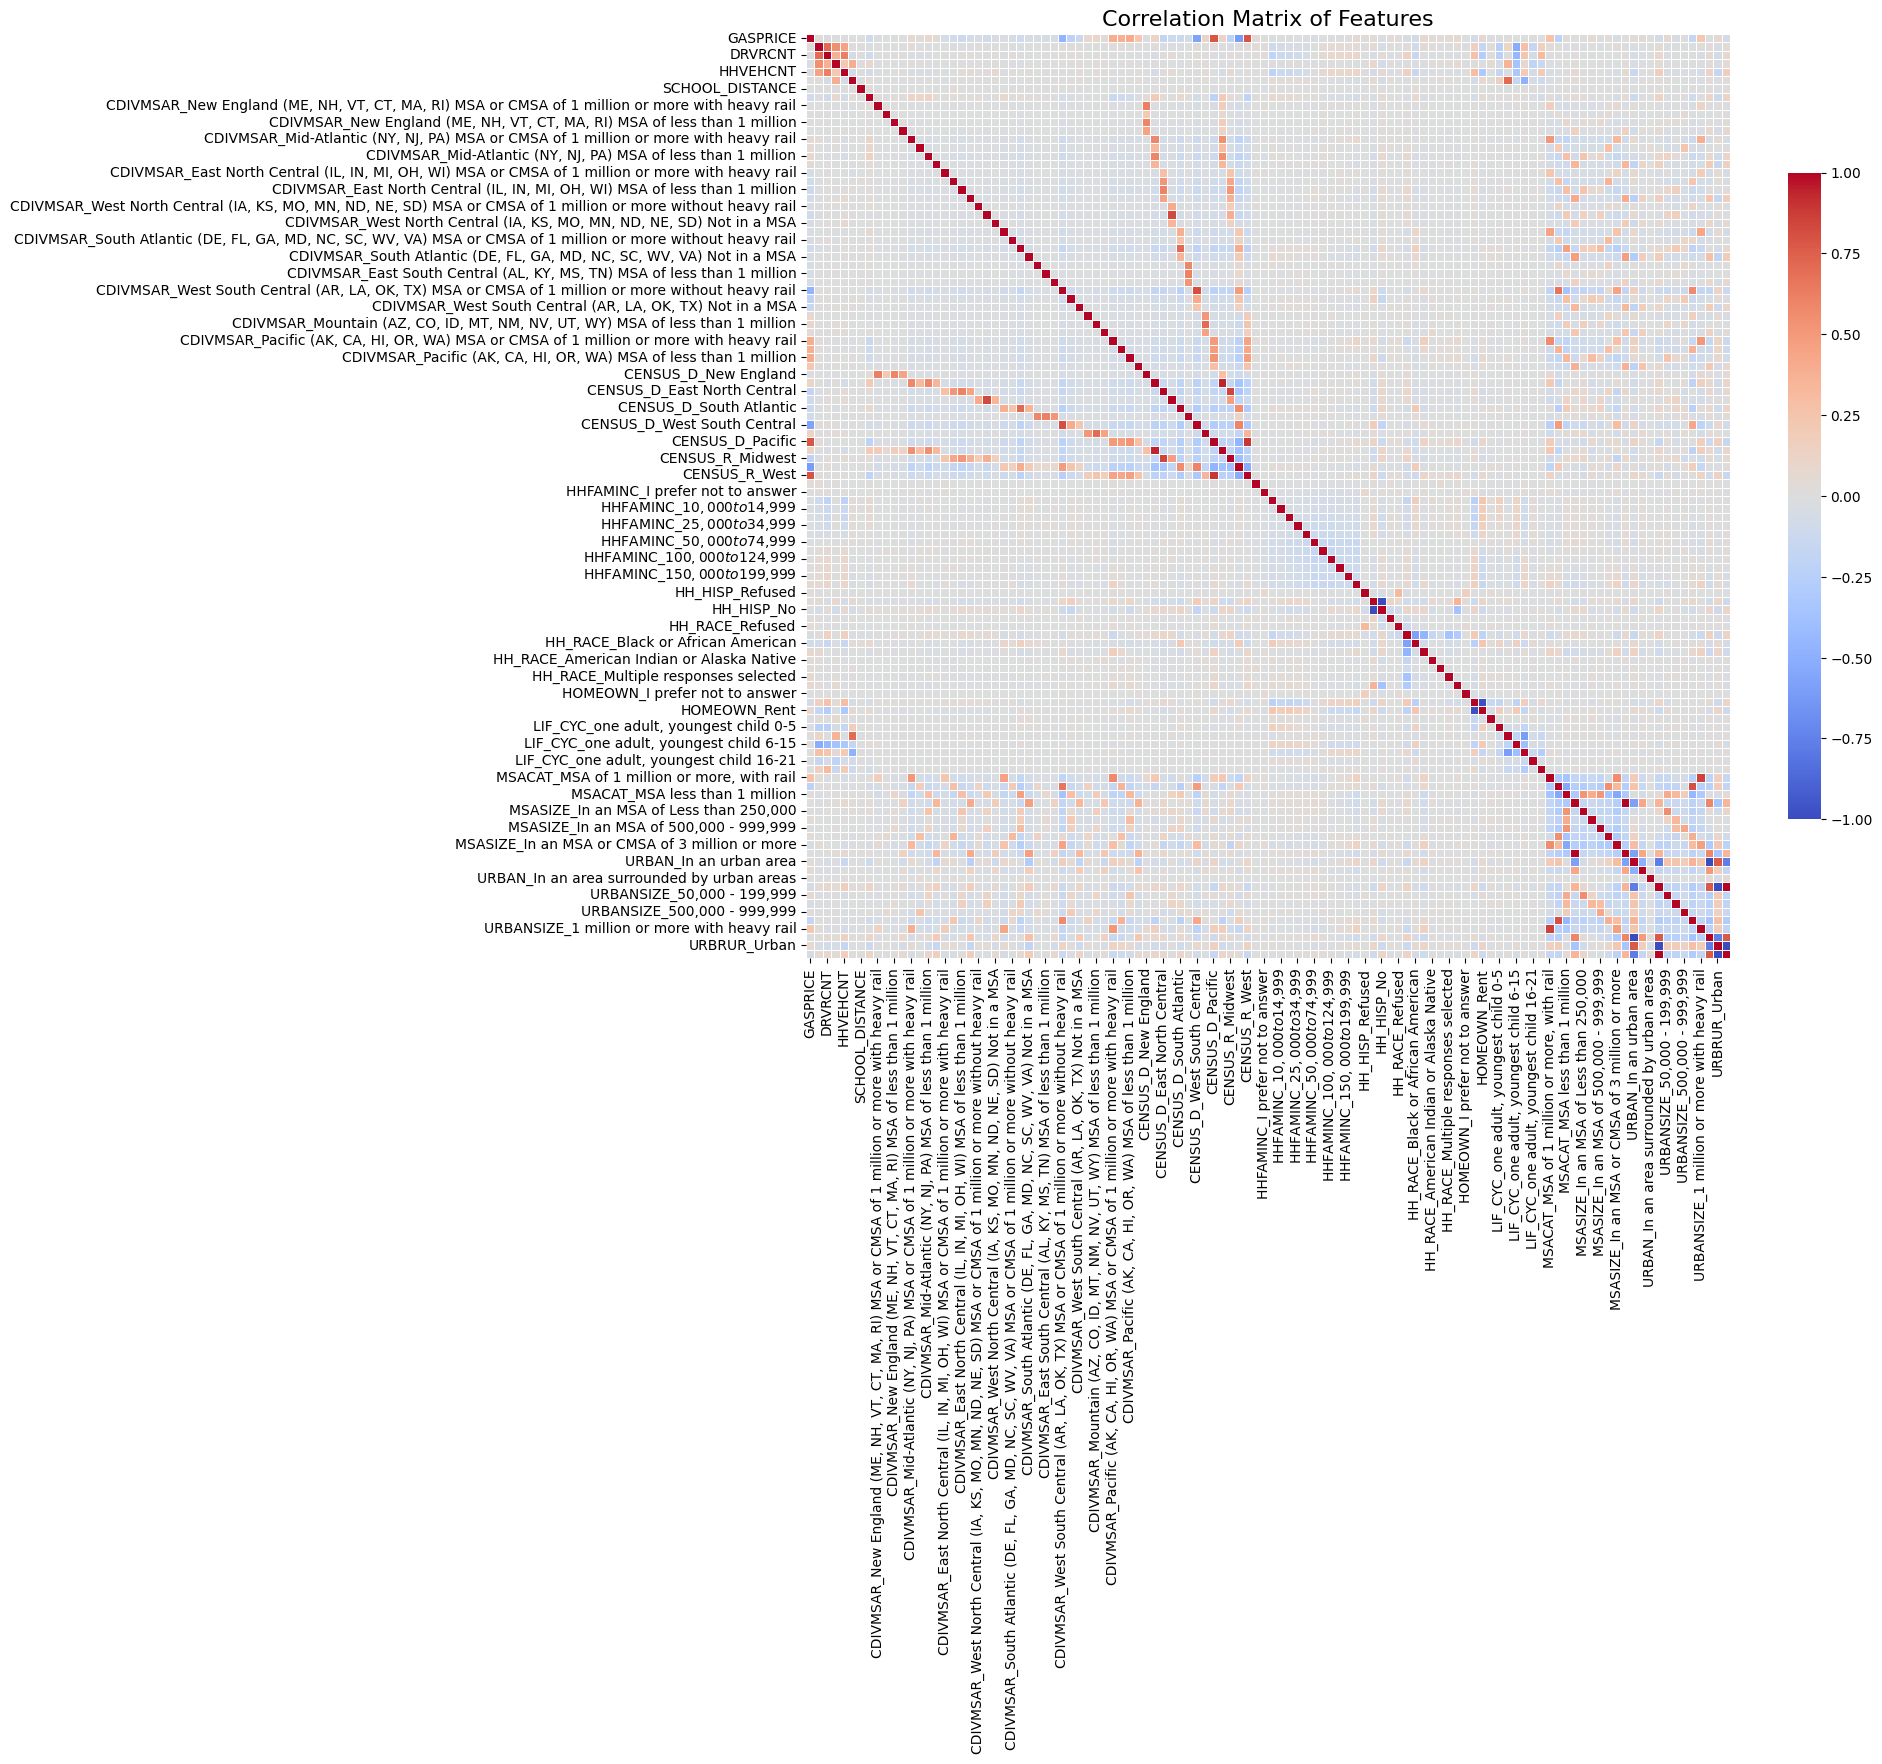

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = onehot_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Draw the heatmap
sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center=0,
            annot=False,  # True if you want the numbers on the heatmap
            fmt=".2f",
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.7})

plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()


**Further Cleanup of Features**

Make boxplots of numerical values to catch outliers.

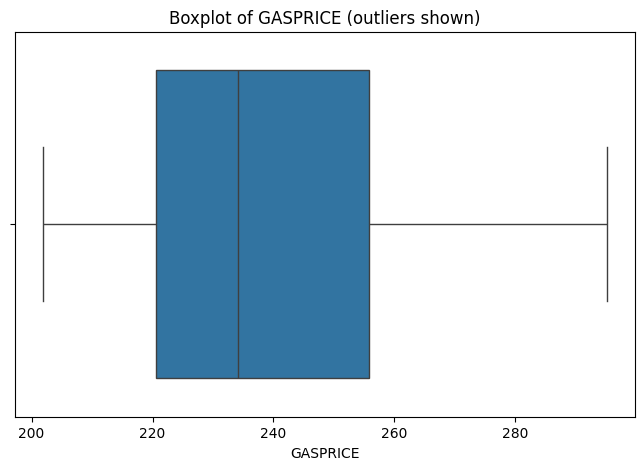

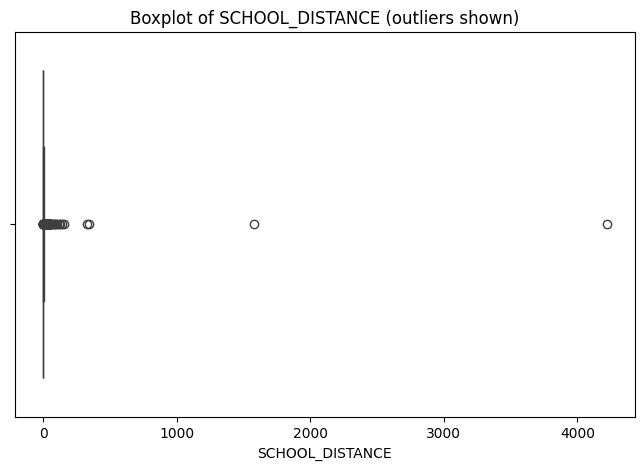

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical variables
numerical_vars = [
    'GASPRICE', 'SCHOOL_DISTANCE'
]

# Loop through each variable and create a boxplot
for var in numerical_vars:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=onehot_df[var])
    plt.title(f'Boxplot of {var} (outliers shown)')
    plt.xlabel(var)
    plt.show()


Let's figure out how many outliers we need to get rid of.

In [29]:
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = series[(series < lower) | (series > upper)]
    return len(outliers), len(outliers) / len(series) * 100

for var in ['GASPRICE', 'SCHOOL_DISTANCE']:
    count, percent = count_outliers(onehot_df[var])
    print(f"{var}: {count} outliers ({percent:.2f}% of total entries)")


GASPRICE: 0 outliers (0.00% of total entries)
SCHOOL_DISTANCE: 3950 outliers (15.07% of total entries)


We can leave the outliers for gas price as is, but we need to take care of the outliers for school distance. Let's visualize the breakdown of school bus users.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


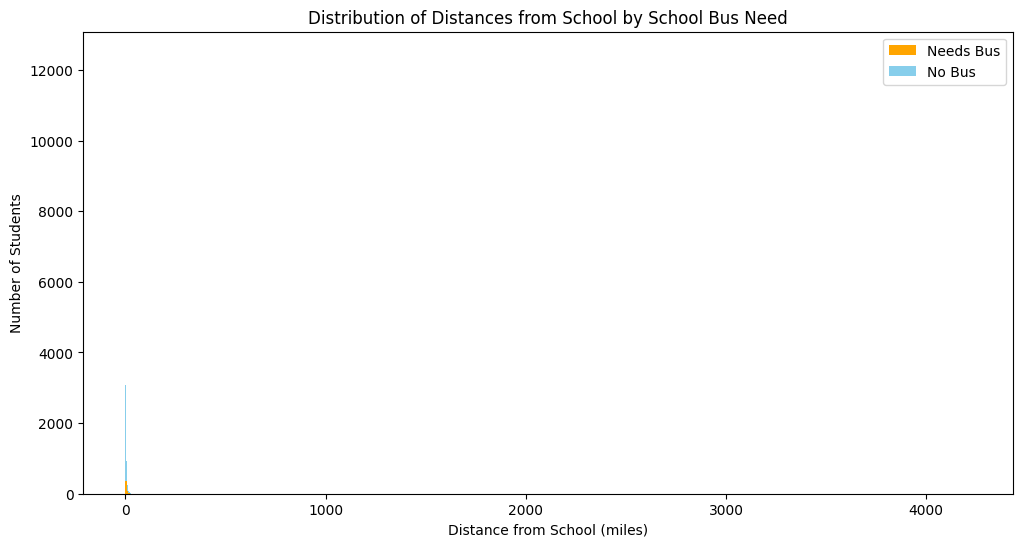

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Define bins every 5 miles
max_distance = student_trips_filtered['SCHOOL_DISTANCE'].max()
bins = np.arange(0, max_distance + 5, 1)

# Split distances by NEED_SCHOOL_BUS
distance_bus = student_trips_filtered[student_trips_filtered['NEEDS_SCHOOL_BUS'] == 1]['SCHOOL_DISTANCE']
distance_no_bus = student_trips_filtered[student_trips_filtered['NEEDS_SCHOOL_BUS'] == 0]['SCHOOL_DISTANCE']

# Plot stacked histogram
plt.figure(figsize=(12,6))
plt.hist([distance_bus, distance_no_bus], bins=bins, stacked=True, color=['orange', 'skyblue'], label=['Needs Bus', 'No Bus'])
plt.xlabel('Distance from School (miles)')
plt.ylabel('Number of Students')
plt.title('Distribution of Distances from School by School Bus Need')
plt.legend()
plt.show()


Let's analyze just the outliers.

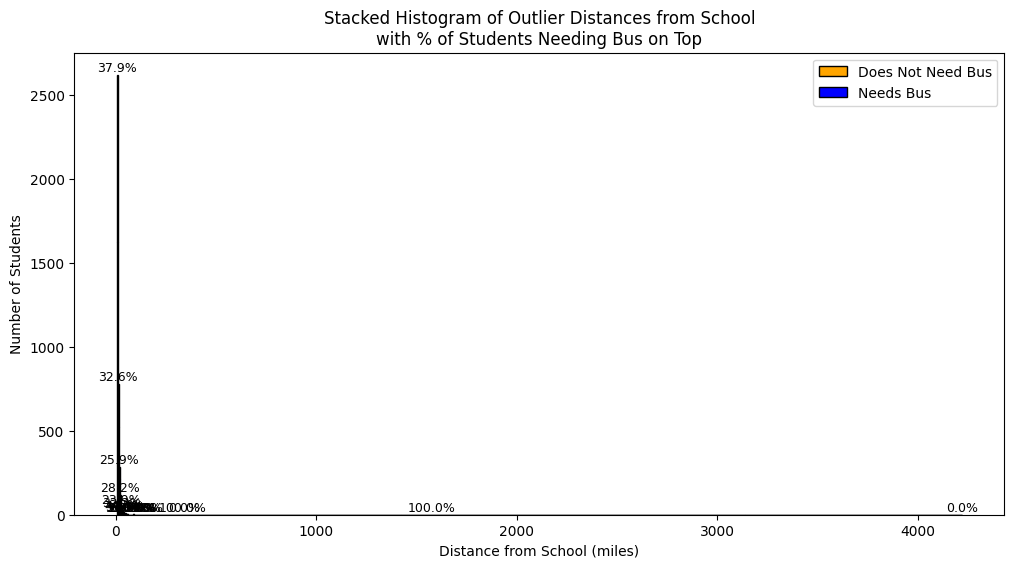

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Identify outliers using 1.5*IQR
Q1 = student_trips_filtered['SCHOOL_DISTANCE'].quantile(0.25)
Q3 = student_trips_filtered['SCHOOL_DISTANCE'].quantile(0.75)
IQR = Q3 - Q1
outliers = student_trips_filtered[student_trips_filtered['SCHOOL_DISTANCE'] > Q3 + 1.5*IQR]

# Define bins
bins = np.arange(outliers['SCHOOL_DISTANCE'].min(), outliers['SCHOOL_DISTANCE'].max() + 5, 5)

# Compute counts per bin
counts_bus1, _ = np.histogram(outliers[outliers['NEEDS_SCHOOL_BUS']==1]['SCHOOL_DISTANCE'], bins=bins)
counts_bus0, _ = np.histogram(outliers[outliers['NEEDS_SCHOOL_BUS']==0]['SCHOOL_DISTANCE'], bins=bins)
counts_total = counts_bus1 + counts_bus0

# Plot stacked histogram
plt.figure(figsize=(12,6))
plt.bar(bins[:-1], counts_bus0, width=5, color='orange', label='Does Not Need Bus', align='edge', edgecolor='black')
plt.bar(bins[:-1], counts_bus1, width=5, bottom=counts_bus0, color='blue', label='Needs Bus', align='edge', edgecolor='black')

# Add percent labels
for i in range(len(bins)-1):
    if counts_total[i] > 0:
        pct = counts_bus1[i] / counts_total[i] * 100
        plt.text(bins[i] + 2.5, counts_total[i] + 1, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

plt.xlabel('Distance from School (miles)')
plt.ylabel('Number of Students')
plt.title('Stacked Histogram of Outlier Distances from School\nwith % of Students Needing Bus on Top')
plt.legend()
plt.show()


Filter out all outliers above 30 miles of distance from school since 0% of these students used a bus (likely edge cases and unrepresentative trips).

In [32]:
# Remove rows where SCHOOL_DISTANCE > 30 miles
student_trips_filtered = student_trips_filtered[student_trips_filtered['SCHOOL_DISTANCE'] <= 30].reset_index(drop=True)


Many schools have a "minimum distance" policy for school bus users.

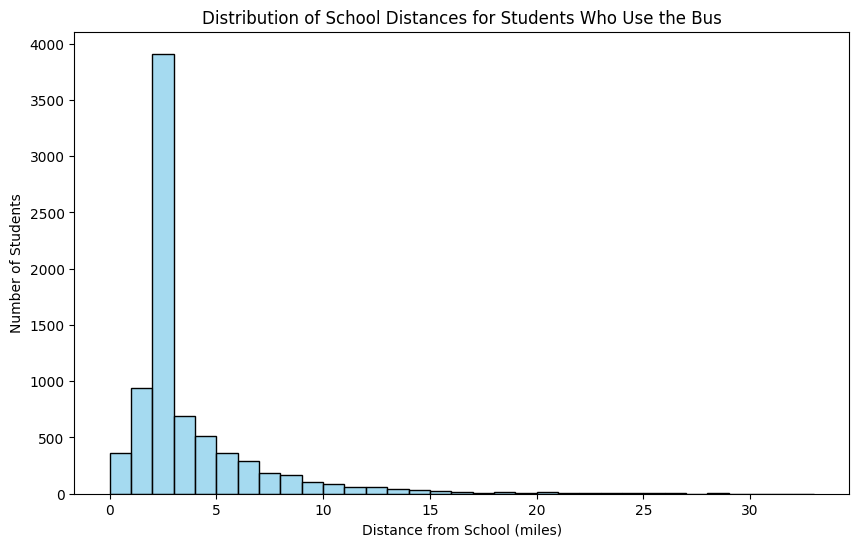

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to students who need a bus
bus_students = student_trips_filtered[student_trips_filtered['NEEDS_SCHOOL_BUS'] == 1]

# Plot histogram
plt.figure(figsize=(10,6))
sns.histplot(bus_students['SCHOOL_DISTANCE'], bins=range(0, int(bus_students['SCHOOL_DISTANCE'].max()) + 5, 1),
             kde=False, color='skyblue', edgecolor='black')
plt.title('Distribution of School Distances for Students Who Use the Bus')
plt.xlabel('Distance from School (miles)')
plt.ylabel('Number of Students')
plt.xticks(range(0, int(bus_students['SCHOOL_DISTANCE'].max()) + 5, 5))
plt.show()


Since there is no known standard minimum distance that we can filter by, it is best to keep all the entries of students. The model will learn that students closer to school do not need a bus (usually because policy dictates that they don't).

Now we need to reduce some more columns based on feasibility. A good started is the heavy rail distinction placed on most categories; this is both infeasible to acquire and not very useful.

Let's also get rid of the MSA distinction within CDIVSMAR since we already have columns for that.

In [34]:
import re

# Step 1. Find all CDIVMSAR_* one-hot columns
cd_cols = [c for c in onehot_df.columns if c.startswith("CDIVMSAR_")]

# Step 2. Extract region name BEFORE the first detailed descriptor
# Example: "CDIVMSAR_Pacific MSA/CMSA of 1 million+ with heavy rail"
# → "CDIVMSAR_Pacific"
def extract_region(colname):
    # Remove "CDIVMSAR_" prefix to isolate the label
    label = colname.replace("CDIVMSAR_", "")
    # Region is the FIRST part before any of these descriptive terms
    region = re.split(r" MSA| CMSA| of | Not ", label)[0].strip()
    return "CDIVMSAR_" + region

# Step 3. Collapse columns by OR-ing all columns belonging to the same region
collapsed = {}

for col in cd_cols:
    region_key = extract_region(col)
    if region_key not in collapsed:
        collapsed[region_key] = onehot_df[col].copy()
    else:
        collapsed[region_key] |= onehot_df[col]   # OR operation

# Step 4. Drop the original detailed columns
onehot_df = onehot_df.drop(columns=cd_cols)

# Step 5. Add back the collapsed region-level columns
for region_key, series in collapsed.items():
    onehot_df[region_key] = series

onehot_df.columns


Index(['GASPRICE', 'NUMADLT', 'DRVRCNT', 'HHSIZE', 'HHVEHCNT', 'YOUNGCHILD',
       'SCHOOL_DISTANCE', 'NEEDS_SCHOOL_BUS', 'CENSUS_D_New England',
       'CENSUS_D_Middle Atlantic', 'CENSUS_D_East North Central',
       'CENSUS_D_West North Central', 'CENSUS_D_South Atlantic',
       'CENSUS_D_East South Central', 'CENSUS_D_West South Central',
       'CENSUS_D_Mountain', 'CENSUS_D_Pacific', 'CENSUS_R_Northeast',
       'CENSUS_R_Midwest', 'CENSUS_R_South', 'CENSUS_R_West',
       'HHFAMINC_I don't know', 'HHFAMINC_I prefer not to answer',
       'HHFAMINC_Less than $10,000', 'HHFAMINC_$10,000 to $14,999',
       'HHFAMINC_$15,000 to $24,999', 'HHFAMINC_$25,000 to $34,999',
       'HHFAMINC_$35,000 to $49,999', 'HHFAMINC_$50,000 to $74,999',
       'HHFAMINC_$75,000 to $99,999', 'HHFAMINC_$100,000 to $124,999',
       'HHFAMINC_$125,000 to $149,999', 'HHFAMINC_$150,000 to $199,999',
       'HHFAMINC_$200,000 or more', 'HH_HISP_Refused', 'HH_HISP_Yes',
       'HH_HISP_No', 'HH_RACE_Don'

Let's also drop Life Cycle, NUMADLT, DRVRCNT, HHSIZE, HHVEHCNT, YOUNGCHILD; although these are likely strong predictors, we cannot feasibly acquire this data for a student.

REMOVED Hometype column (2022 has, 2017 does not)

In [39]:
# Columns to drop completely
cols_to_drop = [
    'HOMEOWN_I prefer not to answer',
    'HOMEOWN_Own',
    'HOMEOWN_Rent',
    'HOMEOWN_Some other arrangement',
    'LIF_CYC_one adult, youngest child 0-5',
    'LIF_CYC_2+ adults, youngest child 0-5',
    'LIF_CYC_one adult, youngest child 6-15',
    'LIF_CYC_2+ adults, youngest child 6-15',
    'LIF_CYC_one adult, youngest child 16-21',
    'LIF_CYC_2+ adults, youngest child 16-21',
    'NUMADLT',
    'DRVRCNT',
    'HHSIZE',
    'HHVEHCNT',
    'YOUNGCHILD'
]

# Drop these columns safely
onehot_df = onehot_df.drop(columns=cols_to_drop, errors='ignore')



Remove highly correlated columns. (deactivated for now)

In [ ]:
"""
# Step 1: Compute correlation matrix for all numeric columns
corr_matrix = onehot_df.corr().abs()  # absolute correlation

# Step 2: Create an upper triangle mask so we don't consider duplicate pairs
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 3: Find columns with correlation greater than threshold
threshold = 0.9
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > threshold)]

print(f"Columns to drop due to high correlation (> {threshold}):")
print(to_drop)

# Step 4: Drop these columns
onehot_df_reduced = onehot_df.drop(columns=to_drop)

print(f"Shape before dropping: {onehot_df.shape}")
print(f"Shape after dropping: {onehot_df_reduced.shape}")

"""

In [40]:
onehot_df.columns

Index(['GASPRICE', 'SCHOOL_DISTANCE', 'NEEDS_SCHOOL_BUS',
       'CENSUS_D_New England', 'CENSUS_D_Middle Atlantic',
       'CENSUS_D_East North Central', 'CENSUS_D_West North Central',
       'CENSUS_D_South Atlantic', 'CENSUS_D_East South Central',
       'CENSUS_D_West South Central', 'CENSUS_D_Mountain', 'CENSUS_D_Pacific',
       'CENSUS_R_Northeast', 'CENSUS_R_Midwest', 'CENSUS_R_South',
       'CENSUS_R_West', 'HHFAMINC_I don't know',
       'HHFAMINC_I prefer not to answer', 'HHFAMINC_Less than $10,000',
       'HHFAMINC_$10,000 to $14,999', 'HHFAMINC_$15,000 to $24,999',
       'HHFAMINC_$25,000 to $34,999', 'HHFAMINC_$35,000 to $49,999',
       'HHFAMINC_$50,000 to $74,999', 'HHFAMINC_$75,000 to $99,999',
       'HHFAMINC_$100,000 to $124,999', 'HHFAMINC_$125,000 to $149,999',
       'HHFAMINC_$150,000 to $199,999', 'HHFAMINC_$200,000 or more',
       'HH_HISP_Refused', 'HH_HISP_Yes', 'HH_HISP_No', 'HH_RACE_Don't know',
       'HH_RACE_Refused', 'HH_RACE_White', 'HH_RACE_Blac

Let's seperate this data into smaller datasets, differentiated by region. We can filter by CDIVMSAR, CENSUS_R, and CENSUS_D, and see which filtration method gives us the highest average recall/precision/ROC_AUC.

In [41]:
# --- Helper function to build subset datasets for any prefix --- #

def build_subsets(df, prefix):
    """
    Creates subsets based on one-hot columns with `prefix`.
    Drops all columns starting with that prefix inside each subset.
    Returns dict of datasets + prints sizes + dataset names.
    """

    # Identify category columns like "CENSUS_R_West", "CDIVMSAR_Pacific", etc.
    category_cols = [c for c in df.columns if c.startswith(prefix)]

    if len(category_cols) == 0:
        print(f"No columns found for prefix: {prefix}")
        return {}, []

    # Columns to drop in each subset
    cols_to_drop = category_cols.copy()

    datasets = {}

    for col in category_cols:
        # Create a readable dataset name
        clean_name = col.replace(prefix, "")
        dataset_name = f"{col}_df"

        # Build subset
        subset_df = df[df[col] == 1].copy()

        # Drop ALL columns in this category
        subset_df = subset_df.drop(columns=cols_to_drop)

        datasets[dataset_name] = subset_df

        print(f"{dataset_name}: {subset_df.shape[0]} rows")

    dataset_names = list(datasets.keys())

    print(f"\nDatasets created for {prefix}:")
    print(dataset_names)
    print("\n" + "-"*60 + "\n")

    return datasets, dataset_names


# --- Build ALL subsets: CDIVMSAR, CENSUS_R, and CENSUS_D --- #

cdivmsar_datasets, cdivmsar_names = build_subsets(onehot_df, "CDIVMSAR_")
census_r_datasets, census_r_names = build_subsets(onehot_df, "CENSUS_R_")
census_d_datasets, census_d_names = build_subsets(onehot_df, "CENSUS_D_")


CDIVMSAR_New England (ME, NH, VT, CT, MA, RI)_df: 362 rows
CDIVMSAR_Mid-Atlantic (NY, NJ, PA)_df: 3425 rows
CDIVMSAR_East North Central (IL, IN, MI, OH, WI)_df: 3030 rows
CDIVMSAR_West North Central (IA, KS, MO, MN, ND, NE, SD)_df: 1027 rows
CDIVMSAR_South Atlantic (DE, FL, GA, MD, NC, SC, WV, VA)_df: 5586 rows
CDIVMSAR_East South Central (AL, KY, MS, TN)_df: 296 rows
CDIVMSAR_West South Central (AR, LA, OK, TX)_df: 6152 rows
CDIVMSAR_Mountain (AZ, CO, ID, MT, NM, NV, UT, WY)_df: 975 rows
CDIVMSAR_Pacific (AK, CA, HI, OR, WA)_df: 5355 rows

Datasets created for CDIVMSAR_:
['CDIVMSAR_New England (ME, NH, VT, CT, MA, RI)_df', 'CDIVMSAR_Mid-Atlantic (NY, NJ, PA)_df', 'CDIVMSAR_East North Central (IL, IN, MI, OH, WI)_df', 'CDIVMSAR_West North Central (IA, KS, MO, MN, ND, NE, SD)_df', 'CDIVMSAR_South Atlantic (DE, FL, GA, MD, NC, SC, WV, VA)_df', 'CDIVMSAR_East South Central (AL, KY, MS, TN)_df', 'CDIVMSAR_West South Central (AR, LA, OK, TX)_df', 'CDIVMSAR_Mountain (AZ, CO, ID, MT, NM, NV, 

Let's train a random forest on each of these datasets and gather their performance scores in a dataframe to analyze.

In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)

# ---------------------------------------------------------
# Helper function to evaluate a dataset with a random forest
# ---------------------------------------------------------

def evaluate_rf(df, target_col="NEEDS_SCHOOL_BUS"):
    """Train-test split + evaluate random forest on a dataset."""
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Skip empty or tiny datasets
    if len(df) < 50:
        return None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    rf = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
    )

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba)
    }

    return metrics


# ---------------------------------------------------------
# Build subsets using the already written function
# ---------------------------------------------------------

cdivmsar_datasets, cdivmsar_names = build_subsets(onehot_df, "CDIVMSAR_")
census_r_datasets, census_r_names = build_subsets(onehot_df, "CENSUS_R_")
census_d_datasets, census_d_names = build_subsets(onehot_df, "CENSUS_D_")


# ---------------------------------------------------------
# Evaluate each dataset and collect metrics
# ---------------------------------------------------------

results = []

def evaluate_category(dataset_dict, names_list, filter_type):
    category_results = []
    for name in names_list:
        df = dataset_dict[name]
        metrics = evaluate_rf(df)
        if metrics is not None:
            metrics["dataset_name"] = name
            metrics["filter_type"] = filter_type
            results.append(metrics)
            category_results.append(metrics)
    return category_results


cdivmsar_results = evaluate_category(cdivmsar_datasets, cdivmsar_names, "CDIVMSAR")
census_r_results = evaluate_category(census_r_datasets, census_r_names, "CENSUS_R")
census_d_results = evaluate_category(census_d_datasets, census_d_names, "CENSUS_D")


# ---------------------------------------------------------
# Convert all results into a DataFrame
# ---------------------------------------------------------

results_df = pd.DataFrame(results)
print(results_df)

# OPTIONAL: pretty sort
results_df = results_df.sort_values(["filter_type", "dataset_name"]).reset_index(drop=True)
results_df


CDIVMSAR_New England (ME, NH, VT, CT, MA, RI)_df: 362 rows
CDIVMSAR_Mid-Atlantic (NY, NJ, PA)_df: 3425 rows
CDIVMSAR_East North Central (IL, IN, MI, OH, WI)_df: 3030 rows
CDIVMSAR_West North Central (IA, KS, MO, MN, ND, NE, SD)_df: 1027 rows
CDIVMSAR_South Atlantic (DE, FL, GA, MD, NC, SC, WV, VA)_df: 5586 rows
CDIVMSAR_East South Central (AL, KY, MS, TN)_df: 296 rows
CDIVMSAR_West South Central (AR, LA, OK, TX)_df: 6152 rows
CDIVMSAR_Mountain (AZ, CO, ID, MT, NM, NV, UT, WY)_df: 975 rows
CDIVMSAR_Pacific (AK, CA, HI, OR, WA)_df: 5355 rows

Datasets created for CDIVMSAR_:
['CDIVMSAR_New England (ME, NH, VT, CT, MA, RI)_df', 'CDIVMSAR_Mid-Atlantic (NY, NJ, PA)_df', 'CDIVMSAR_East North Central (IL, IN, MI, OH, WI)_df', 'CDIVMSAR_West North Central (IA, KS, MO, MN, ND, NE, SD)_df', 'CDIVMSAR_South Atlantic (DE, FL, GA, MD, NC, SC, WV, VA)_df', 'CDIVMSAR_East South Central (AL, KY, MS, TN)_df', 'CDIVMSAR_West South Central (AR, LA, OK, TX)_df', 'CDIVMSAR_Mountain (AZ, CO, ID, MT, NM, NV, 

,accuracy,precision,recall,f1,roc_auc,dataset_name,filter_type
0,0.745875,0.661111,0.561321,0.607143,0.775315,"CDIVMSAR_East North Central (IL, IN, MI, OH, W...",CDIVMSAR
1,0.766667,0.695652,0.695652,0.695652,0.819624,"CDIVMSAR_East South Central (AL, KY, MS, TN)_df",CDIVMSAR
2,0.719708,0.732323,0.771277,0.751295,0.790307,"CDIVMSAR_Mid-Atlantic (NY, NJ, PA)_df",CDIVMSAR
3,0.764103,0.657895,0.431034,0.520833,0.803612,"CDIVMSAR_Mountain (AZ, CO, ID, MT, NM, NV, UT,...",CDIVMSAR
4,0.589041,0.533333,0.500000,0.516129,0.625762,"CDIVMSAR_New England (ME, NH, VT, CT, MA, RI)_df",CDIVMSAR
5,0.905696,0.581081,0.380531,0.459893,0.773847,"CDIVMSAR_Pacific (AK, CA, HI, OR, WA)_df",CDIVMSAR
6,0.738819,0.680723,0.548544,0.607527,0.777851,"CDIVMSAR_South Atlantic (DE, FL, GA, MD, NC, S...",CDIVMSAR
7,0.737864,0.596774,0.560606,0.578125,0.745725,"CDIVMSAR_West North Central (IA, KS, MO, MN, N...",CDIVMSAR
8,0.800162,0.614719,0.474916,0.535849,0.747562,"CDIVMSAR_West South Central (AR, LA, OK, TX)_df",CDIVMSAR
9,0.737624,0.643243,0.561321,0.599496,0.771789,CENSUS_D_East North Central_df,CENSUS_D


Don't forget to include the overall dataset to compare with.

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# -------------------------
# 1. Prepare features and target
# -------------------------
X = onehot_df.drop(columns=['NEEDS_SCHOOL_BUS'])
y = onehot_df['NEEDS_SCHOOL_BUS']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------
# 2. Train Random Forest
# -------------------------
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight='balanced'  # handles class imbalance
)
rf.fit(X_train, y_train)

# -------------------------
# 3. Predict and compute metrics
# -------------------------
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

all_metrics = {
    "filter_type": "All",
    "dataset_name": "All_Data",
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba)
}

# -------------------------
# 4. Append to results_df
# -------------------------
import pandas as pd

results_df = pd.concat([results_df, pd.DataFrame([all_metrics])], ignore_index=True)

# -------------------------
# 5. Check
# -------------------------
print(results_df.tail())


    accuracy  precision    recall        f1   roc_auc           dataset_name  \
18  0.727833   0.610895  0.564748  0.586916  0.762758    CENSUS_R_Midwest_df   
19  0.696570   0.713942  0.727941  0.720874  0.773029  CENSUS_R_Northeast_df   
20  0.765683   0.631825  0.552524  0.589520  0.764491      CENSUS_R_South_df   
21  0.903633   0.696000  0.508772  0.587838  0.843892       CENSUS_R_West_df   
22  0.786150   0.669811  0.580868  0.622177  0.816275               All_Data   

   filter_type  
18    CENSUS_R  
19    CENSUS_R  
20    CENSUS_R  
21    CENSUS_R  
22         All  


Let's visualize the spread of each of these metrics across the three categories. We can plot bar graphs to seperately show the distribution of scores within a filter category, and compare across filter categories. We can also compare average scores across categories.

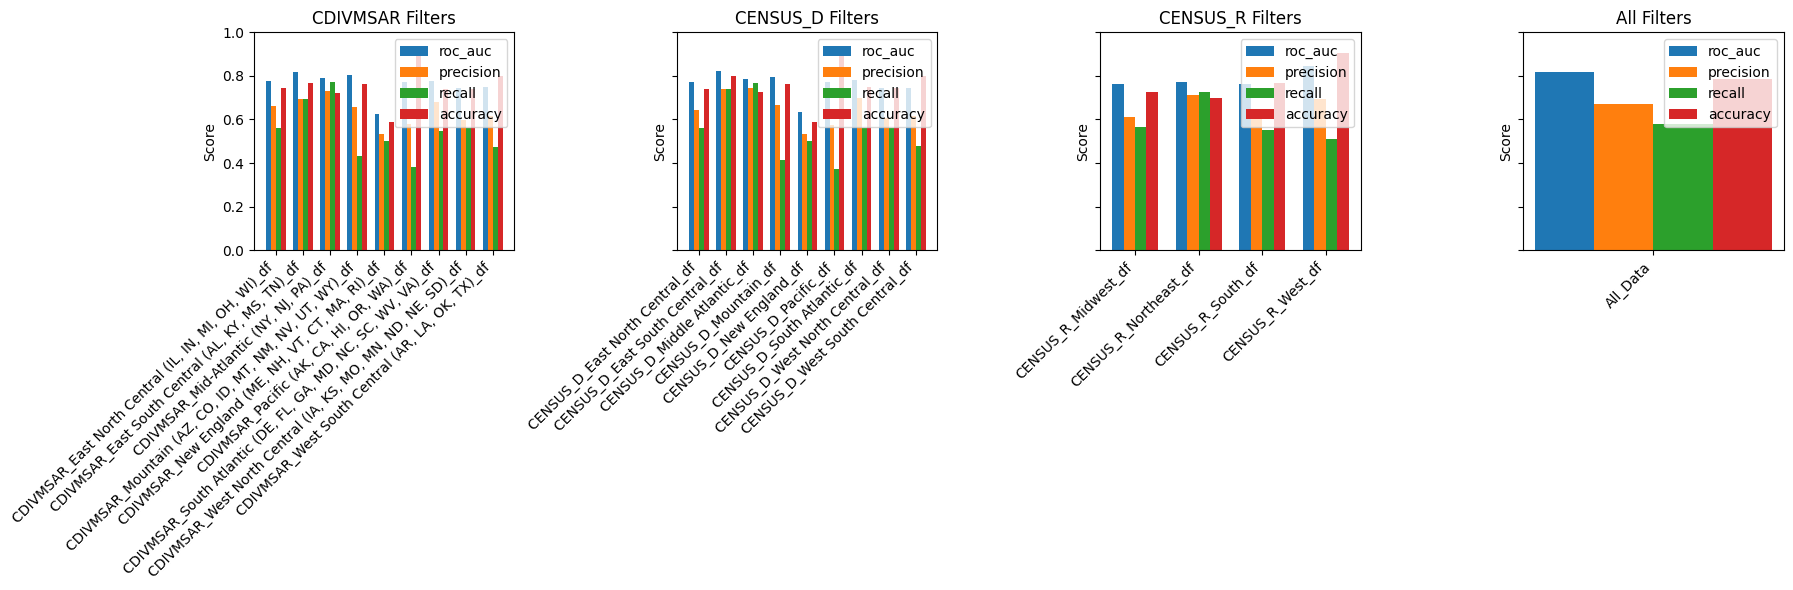

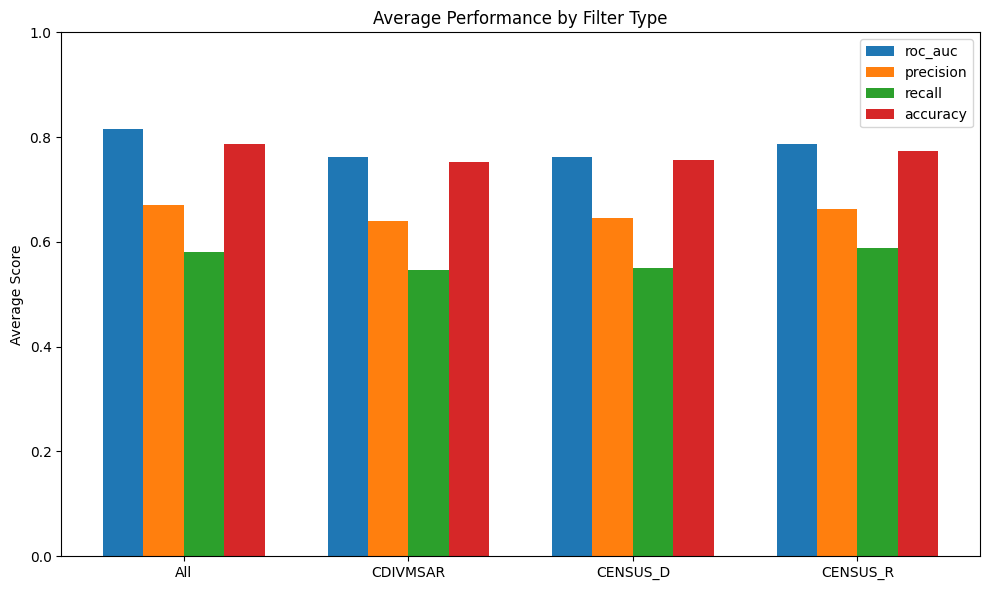

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# 1. Bar charts for each filter type
# -------------------------

metrics = ["roc_auc", "precision", "recall", "accuracy"]
filter_types = results_df["filter_type"].unique()

fig, axes = plt.subplots(1, len(filter_types), figsize=(18, 6), sharey=True)

for ax, ftype in zip(axes, filter_types):
    subset = results_df[results_df["filter_type"] == ftype]
    dataset_names = subset["dataset_name"].tolist()

    x = np.arange(len(dataset_names))
    width = 0.18

    for i, metric in enumerate(metrics):
        ax.bar(x + i*width, subset[metric].values, width, label=metric)

    ax.set_title(f"{ftype} Filters")
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(dataset_names, rotation=45, ha="right")
    ax.set_ylim(0, 1)  # same scale across all charts
    ax.set_ylabel("Score")
    ax.legend()

plt.tight_layout()
plt.show()

# -------------------------
# 2. Bar chart of average scores per filter
# -------------------------

avg_df = results_df.groupby("filter_type")[metrics].mean().reset_index()

x = np.arange(len(avg_df["filter_type"]))
width = 0.18

plt.figure(figsize=(10, 6))

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, avg_df[metric].values, width, label=metric)

plt.title("Average Performance by Filter Type")
plt.xticks(x + width * 1.5, avg_df["filter_type"])
plt.ylabel("Average Score")
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()


Looks like seperating it out helped boost the recall, which is good.

Let's rank the top 20 rows by recall.

In [47]:
top_20_recall = results_df.sort_values(by='recall', ascending=False).head(20).reset_index(drop=True)
print(top_20_recall)


    accuracy  precision    recall        f1   roc_auc  \
0   0.719708   0.732323  0.771277  0.751295  0.790307   
1   0.725547   0.742268  0.765957  0.753927  0.787626   
2   0.800000   0.739130  0.739130  0.739130  0.823737   
3   0.696570   0.713942  0.727941  0.720874  0.773029   
4   0.766667   0.695652  0.695652  0.695652  0.819624   
5   0.786150   0.669811  0.580868  0.622177  0.816275   
6   0.727833   0.610895  0.564748  0.586916  0.762758   
7   0.748658   0.696697  0.563107  0.622819  0.780582   
8   0.745875   0.661111  0.561321  0.607143  0.775315   
9   0.737624   0.643243  0.561321  0.599496  0.771789   
10  0.737864   0.596774  0.560606  0.578125  0.745725   
11  0.742718   0.606557  0.560606  0.582677  0.744697   
12  0.765683   0.631825  0.552524  0.589520  0.764491   
13  0.738819   0.680723  0.548544  0.607527  0.777851   
14  0.903633   0.696000  0.508772  0.587838  0.843892   
15  0.589041   0.533333  0.500000  0.516129  0.625762   
16  0.589041   0.533333  0.5000

Let's see if we can boost the scores at all by applying SMOTE and lowering the threshold to prioritize recall for every dataset.

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
from imblearn.over_sampling import SMOTE

# ---------------------------------------------------------
# Helper function to evaluate a dataset with a random forest + SMOTE + threshold
# ---------------------------------------------------------
def evaluate_rf_smote(df, target_col="NEEDS_SCHOOL_BUS", threshold=0.35):
    """Train-test split + SMOTE + Random Forest + evaluate metrics."""
    X = df.drop(columns=[target_col])
    y = df[target_col]

    if len(df) < 50:  # skip tiny datasets
        return None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Apply SMOTE to the training data
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    # Train Random Forest
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        class_weight='balanced'
    )
    rf.fit(X_train_res, y_train_res)

    # Predict probabilities
    y_proba = rf.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)  # custom threshold

    # Compute metrics
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba)
    }

    return metrics

# ---------------------------------------------------------
# Evaluate category helper
# ---------------------------------------------------------
def evaluate_category_smote(dataset_dict, names_list, filter_type):
    results = []
    for name in names_list:
        df = dataset_dict[name]
        metrics = evaluate_rf_smote(df)
        if metrics is not None:
            metrics["dataset_name"] = name
            metrics["filter_type"] = filter_type
            results.append(metrics)
    return results

# ---------------------------------------------------------
# Build subsets (reuse your existing function)
# ---------------------------------------------------------
cdivmsar_datasets, cdivmsar_names = build_subsets(onehot_df, "CDIVMSAR_")
census_r_datasets, census_r_names = build_subsets(onehot_df, "CENSUS_R_")
census_d_datasets, census_d_names = build_subsets(onehot_df, "CENSUS_D_")

# ---------------------------------------------------------
# Evaluate each subset with SMOTE
# ---------------------------------------------------------
results = []

cdivmsar_results = evaluate_category_smote(cdivmsar_datasets, cdivmsar_names, "CDIVMSAR")
census_r_results = evaluate_category_smote(census_r_datasets, census_r_names, "CENSUS_R")
census_d_results = evaluate_category_smote(census_d_datasets, census_d_names, "CENSUS_D")

# Combine all results
for r in (cdivmsar_results + census_r_results + census_d_results):
    results.append(r)

# ---------------------------------------------------------
# Evaluate entire dataset
# ---------------------------------------------------------
all_metrics = evaluate_rf_smote(onehot_df)
if all_metrics is not None:
    all_metrics["filter_type"] = "All"
    all_metrics["dataset_name"] = "All_Data"
    results.append(all_metrics)

# ---------------------------------------------------------
# Convert to DataFrame
# ---------------------------------------------------------
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(["filter_type", "dataset_name"]).reset_index(drop=True)

print(results_df.head())


CDIVMSAR_New England (ME, NH, VT, CT, MA, RI)_df: 362 rows
CDIVMSAR_Mid-Atlantic (NY, NJ, PA)_df: 3425 rows
CDIVMSAR_East North Central (IL, IN, MI, OH, WI)_df: 3030 rows
CDIVMSAR_West North Central (IA, KS, MO, MN, ND, NE, SD)_df: 1027 rows
CDIVMSAR_South Atlantic (DE, FL, GA, MD, NC, SC, WV, VA)_df: 5586 rows
CDIVMSAR_East South Central (AL, KY, MS, TN)_df: 296 rows
CDIVMSAR_West South Central (AR, LA, OK, TX)_df: 6152 rows
CDIVMSAR_Mountain (AZ, CO, ID, MT, NM, NV, UT, WY)_df: 975 rows
CDIVMSAR_Pacific (AK, CA, HI, OR, WA)_df: 5355 rows

Datasets created for CDIVMSAR_:
['CDIVMSAR_New England (ME, NH, VT, CT, MA, RI)_df', 'CDIVMSAR_Mid-Atlantic (NY, NJ, PA)_df', 'CDIVMSAR_East North Central (IL, IN, MI, OH, WI)_df', 'CDIVMSAR_West North Central (IA, KS, MO, MN, ND, NE, SD)_df', 'CDIVMSAR_South Atlantic (DE, FL, GA, MD, NC, SC, WV, VA)_df', 'CDIVMSAR_East South Central (AL, KY, MS, TN)_df', 'CDIVMSAR_West South Central (AR, LA, OK, TX)_df', 'CDIVMSAR_Mountain (AZ, CO, ID, MT, NM, NV, 

Visualizations.

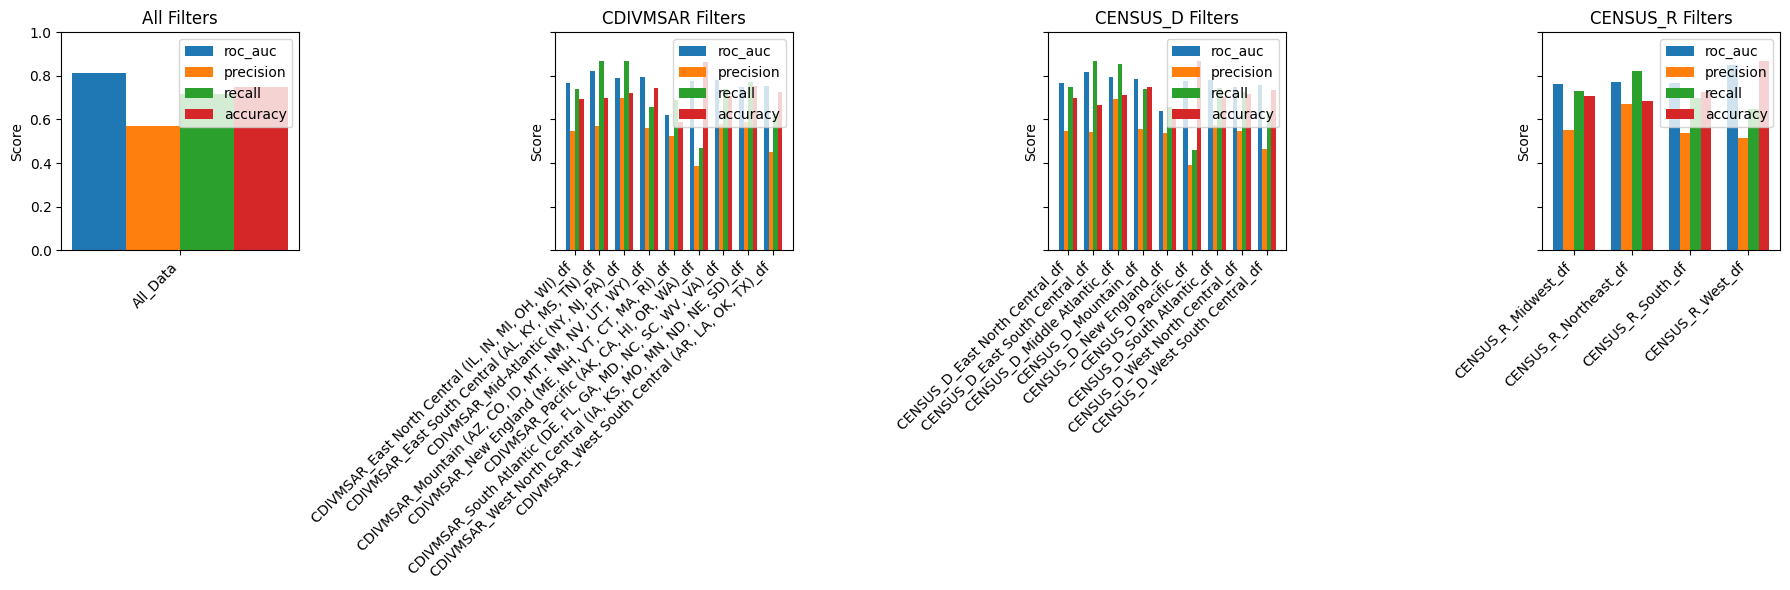

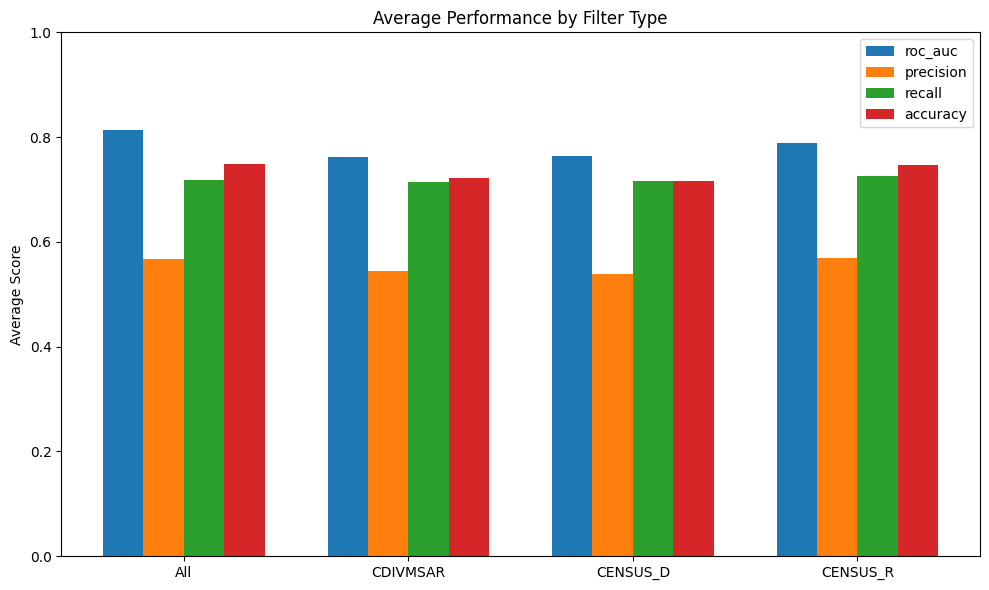

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# 1. Bar charts for each filter type
# -------------------------

metrics = ["roc_auc", "precision", "recall", "accuracy"]
filter_types = results_df["filter_type"].unique()

fig, axes = plt.subplots(1, len(filter_types), figsize=(18, 6), sharey=True)

for ax, ftype in zip(axes, filter_types):
    subset = results_df[results_df["filter_type"] == ftype]
    dataset_names = subset["dataset_name"].tolist()

    x = np.arange(len(dataset_names))
    width = 0.18

    for i, metric in enumerate(metrics):
        ax.bar(x + i*width, subset[metric].values, width, label=metric)

    ax.set_title(f"{ftype} Filters")
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(dataset_names, rotation=45, ha="right")
    ax.set_ylim(0, 1)  # same scale across all charts
    ax.set_ylabel("Score")
    ax.legend()

plt.tight_layout()
plt.show()

# -------------------------
# 2. Bar chart of average scores per filter
# -------------------------

avg_df = results_df.groupby("filter_type")[metrics].mean().reset_index()

x = np.arange(len(avg_df["filter_type"]))
width = 0.18

plt.figure(figsize=(10, 6))

for i, metric in enumerate(metrics):
    plt.bar(x + i*width, avg_df[metric].values, width, label=metric)

plt.title("Average Performance by Filter Type")
plt.xticks(x + width * 1.5, avg_df["filter_type"])
plt.ylabel("Average Score")
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()


Rankings.

In [50]:
top_20_recall = results_df.sort_values(by='recall', ascending=False).head(20).reset_index(drop=True)
print(top_20_recall)


    accuracy  precision    recall        f1   roc_auc  \
0   0.721168   0.697228  0.869681  0.773964  0.790031   
1   0.700000   0.571429  0.869565  0.689655  0.823737   
2   0.666667   0.540541  0.869565  0.666667  0.818449   
3   0.712409   0.692473  0.856383  0.765755  0.793143   
4   0.686016   0.669323  0.823529  0.738462  0.771943   
5   0.752427   0.586207  0.772727  0.666667  0.747890   
6   0.696370   0.548276  0.750000  0.633466  0.769179   
7   0.701252   0.573034  0.742718  0.646934  0.780245   
8   0.748718   0.558442  0.741379  0.637037  0.787314   
9   0.693069   0.545139  0.740566  0.628000  0.768186   
10  0.706619   0.580153  0.737864  0.649573  0.781339   
11  0.705665   0.553134  0.730216  0.629457  0.762499   
12  0.718447   0.545455  0.727273  0.623377  0.747294   
13  0.749142   0.568227  0.718062  0.634418  0.812760   
14  0.724969   0.537329  0.697135  0.606888  0.768641   
15  0.589041   0.523810  0.687500  0.594595  0.622713   
16  0.602740   0.538462  0.6562

Save the cleaned dataframe.

In [51]:
# Save the dataframe as CSV
onehot_df.to_csv('2017_OneHot_V1.csv', index=False)

from google.colab import files

files.download('2017_OneHot_V1.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>